### Controle Quântico Ótimo - Utilização do BFGS para ajuste do caminho percorrido por uma partícula

Nessa etapa, é necessário avaliar, a partir da equação de Heisenberg, com o método de Runge-Kutta e com o controle MPC, como a curva de origem ajusta-se a curva de destino. Além disso, é interessantíssimo a avaliação a partir do estado estacionário e ainda verificar como ocorre o ajuste de fases.

In [1]:
# Bilbiotecas para auxílio na programação matemática
import math, sys 
import numpy as np
import sympy as sp

from scipy import sparse # Produção das diagonais das matrizes
from scipy.sparse import diags 

# Plotagem 2D e 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


from os import path # Suficiente para manipulação de arquivos
    
# Para solução exata
from scipy.special import hermite
from math import factorial

%matplotlib inline
count = 0

# Para otimização dos sistemas
from scipy import optimize

import random

Abaixo se dão os requisitos básicos para a instauração do teste. Se tem formas de subtrair e somar matrizes, a manipulação das derivadas com o Runge-Kutta além da própria proposta da função objetivo.

In [2]:
def somar(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] + B[i][j]

    return C

def sub(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] - B[i][j]

    return C


#################################################################

## d (psi) / dt = -i * H * |psi>
def dpsidt(t,psi, H):
    A = np.zeros((2,2), dtype=np.complex_)
    A = np.dot(complex(0,1),H) # i * H
    return -1*np.matmul(A,psi)

# Runge-Kutta de quarta ordem
def rungeKutta(psi0, h, H, t = 2, t0 = 0):
    
    n = (int)((t-t0))
    S = np.zeros((2,int(t)), dtype=np.complex_)
    r = 0
    
    for i in range(0, n):
        
        S[0][r] = psi0[0][0]
        S[1][r] = psi0[1][0]
        
        k1 = dpsidt(t0, psi0, H)
        k2 = dpsidt(t0 + 0.5 * h, somar(psi0, np.dot((0.5*h), k1)), H)
        k3 = dpsidt(t0 + 0.5 * h, somar(psi0, np.dot((0.5*h), k2)), H)
        k4 = dpsidt(t0 + h, somar(psi0, np.dot(h, k3)), H)
        
        ## y(i+1) = y(i) + h/6*(k1+2*k2+2*k3+k4)
        
        A = somar(np.dot(2,k3), k4)
        B = somar(np.dot(2,k2), k1)
        C = somar(A, B)
 
        psi0 = somar(psi0,np.dot((h / 6.0),(C)))
    
        t0 = t0 + h
        
        r = r + 1
        
    return S

def fo(x, D, H, i, psi0):
    
    H1 = np.zeros((2,2), dtype=np.complex_)
    
    ## Tamanho do horizonte
    tam = 3
    
    M = np.zeros((2,1),dtype=np.complex_)
    M = [[psi0[0][0]], [psi0[1][0]]] 
    
    Result = np.zeros((2,1),dtype=np.complex_)
    
    Return = 0
    
    Z = np.zeros((2,1),dtype=np.complex_)
    Z[0][0] = D[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100)
    Z[1][0] = D[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/100)
    Return += np.linalg.norm(M-Z)**2
    Result = rungeKutta(M, h, somar(H,H1), t = 2, t0 = 0)
    M = Result
    
    teste = tam + i
    
    ## Função-Objetivo (Return) = somatorio ||(Matriz_Origem - Matriz_Destino)||^2
    for p in range(i, teste):
        H1 = [[0, x[p-i]], [x[p-i], 0]] # Controle
        Z = np.zeros((2,1),dtype=np.complex_)
        Z[0][0] = D[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*(p+1)/100)
        Z[1][0] = D[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*(p+1)/100)
        Return += np.linalg.norm(M-Z)**2
        Result = rungeKutta(M, h, somar(H,H1), t = (p-i)+3, t0 = 0)
        M = Result
    
    return Return

def real_to_complex(z):      # real vector of length 2n -> complex of length n
    return z[:len(z)//2] + 1j * z[len(z)//2:]

def complex_to_real(z):      # complex vector of length n -> real of length 2n
    return np.concatenate((np.real(z), np.imag(z)))

Para o funcionamento do MPC, cria-se um looping que consiste em uma otimização não linear, com o apoio da biblioteca de otimização do pyhton, de forma a obter o melhor resultado para o ajuste da curva. Com esse valor em mãos, utiliza-se para os pontos da próxima iteração do método de controle além de efetivar o ajuste realizando o Runge-Kutta com o valor otimizado.

In [3]:
# Horizonte de análise
tam = 3
i = 0 # Iteração
h = 0.01 # Fator Runge-Kutta

# Proposta dos pontos - chutes iniciais
x = []
x.append(random.uniform(-1., 1.)+1j*random.uniform(-1., 1.))
for l in range(1, tam):
    x.append(x[0])

# Função de origem e destino
psi0 = [[complex(0.80,7.0)],[complex(0.60,7.0)]]
psid = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]


H = np.zeros((2,2), dtype=np.complex_) # Hamiltoniano
A = (1/2*np.pi)
B = (3/2*np.pi)
H = [[A, 0], [0, B]]

D = np.zeros((2,1), dtype=np.complex_) # Matriz destino
D[0][0] = psid[0][0]
D[1][0] = psid[1][0]

Resp = np.zeros((2, 2000), dtype=np.complex_)
Constantes = np.zeros((2, 2000), dtype=np.complex_)

while i < 2000:
    
    Resp[0][i] = psi0[0][0]
    Resp[1][i] = psi0[1][0]
    
    # Constantes da função de onda
    Constantes[0][i] = psi0[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100)
    Constantes[1][i] = psi0[1][0] / np.exp(-1*complex(0,1)*(3/2*np.pi)*i/100)
    
    resultado = optimize.minimize(lambda z: fo(real_to_complex(z), D, H, i, psi0), x0=complex_to_real(x), method='CG')
    
    print(resultado)
    
    x = []
    x.append(resultado.x[0])
    for l in range(1, tam):
        x.append(x[0])
    
    ## Hamiltoniano corntrolado
    u = np.zeros((2,1), dtype=np.complex_)
    u = [[0, resultado.x[0]],[np.conj(resultado.x[0]), 0]]
    H = somar(H, u)
    
    ## Adaptação da onda ao controle
    psi_t = np.zeros((2,2), dtype=np.complex_)
    psi_t = rungeKutta(psi0, h, H, t = 2, t0 = 0)
    
    psi0[0][0] = psi_t[0][1]
    psi0[1][0] = psi_t[1][1]
    
    H = [[A, 0], [0, B]]
    
    i = i + 1

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 512.1201048957564
       x: [ 8.260e+01  6.482e+01 -4.017e-01 -1.326e+02 -9.965e+01
           -5.505e-01]
     nit: 16
     jac: [ 7.629e-06  7.629e-06  0.000e+00  0.000e+00  7.629e-06
            0.000e+00]
    nfev: 455
    njev: 65
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 448.05331150050705
       x: [ 6.282e+01  4.640e+01  8.260e+01 -1.179e+02 -8.309e+01
            0.000e+00]
     nit: 14
     jac: [ 3.815e-06 -3.815e-06  0.000e+00  3.815e-06  0.000e+00
            0.000e+00]
    nfev: 385
    njev: 55
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 438.7649681577209
       x: [ 3.074e+01  1.448e+01  6.282e+01 -1.013e+02 -7.147e+01
            0.000e+00]
     nit: 24
     jac: [ 3.815e-06  0.000e+00  0.000e+00 -3.815e-06 -7.629e-06
            0.000e+00]
    nfev: 679
    njev: 97
 message: Optimization terminated su

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 695.4301061898599
       x: [-2.082e-02  2.320e-01 -2.557e-02 -2.422e+01 -1.707e+01
            0.000e+00]
     nit: 20
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00]
    nfev: 385
    njev: 55
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 703.300258420461
       x: [-1.890e-02  2.208e-01 -2.082e-02 -2.299e+01 -1.619e+01
            0.000e+00]
     nit: 16
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00]
    nfev: 329
    njev: 47
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 710.8856535587529
       x: [-1.817e-02  2.092e-01 -1.890e-02 -2.179e+01 -1.534e+01
            0.000e+00]
     nit: 27
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00]
    nfev: 455
    njev: 65
 message: Optimization terminated succ

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 795.1189592727253
       x: [-3.430e-03 -3.513e-02 -3.198e-03  1.582e+00  1.331e+00
            0.000e+00]
     nit: 9
     jac: [ 0.000e+00  0.000e+00  0.000e+00 -7.629e-06  0.000e+00
            0.000e+00]
    nfev: 161
    njev: 23
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 794.2319594587855
       x: [-3.336e-03 -4.461e-02 -3.430e-03  2.477e+00  1.970e+00
            0.000e+00]
     nit: 14
     jac: [ 0.000e+00 -7.629e-06  0.000e+00  0.000e+00 -7.629e-06
            0.000e+00]
    nfev: 238
    njev: 34
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 792.9853891191322
       x: [-3.625e-03 -5.392e-02 -3.336e-03  3.373e+00  2.611e+00
            0.000e+00]
     nit: 17
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00]
    nfev: 259
    njev: 37
 message: Optimization terminated succ

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 663.1501093844653
       x: [-1.382e-02 -2.564e-01 -1.380e-02  2.858e+01  2.070e+01
            0.000e+00]
     nit: 23
     jac: [ 0.000e+00  0.000e+00  0.000e+00 -7.629e-06 -7.629e-06
            0.000e+00]
    nfev: 413
    njev: 59
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 654.1108601821516
       x: [-1.552e-02 -2.633e-01 -1.382e-02  2.998e+01  2.172e+01
            0.000e+00]
     nit: 19
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  1.526e-05
            0.000e+00]
    nfev: 522
    njev: 73
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 644.8366135277533
       x: [-1.713e-02 -2.699e-01 -1.552e-02  3.144e+01  2.277e+01
            0.000e+00]
     nit: 26
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00]
    nfev: 497
    njev: 71
 message: Op

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 634.8377725962357
       x: [ 8.772e+01  8.271e+01  6.961e+01  1.241e+02  8.740e+01
            0.000e+00]
     nit: 17
     jac: [ 7.629e-06 -7.629e-06  0.000e+00 -7.629e-06  7.629e-06
            0.000e+00]
    nfev: 511
    njev: 73
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 628.0623462227107
       x: [ 9.900e+01  9.295e+01  8.772e+01  1.410e+02  9.777e+01
            0.000e+00]
     nit: 14
     jac: [-7.629e-06  7.629e-06  0.000e+00  7.629e-06 -7.629e-06
            0.000e+00]
    nfev: 413
    njev: 59
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 567.6565170693281
       x: [ 9.900e+01  9.509e+01  9.900e+01  1.152e+02  8.162e+01
            0.000e+00]
     nit: 11
     jac: [ 0.000e+00  7.629e-06  0.000e+00  0.000e+00 -7.629e-06
            0.000e+00]
    nfev: 308
    njev: 44
 message: Optimization terminated suc

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 487.1798115877962
       x: [ 1.892e-01 -8.920e-01  1.868e-01  6.117e+01  4.339e+01
            0.000e+00]
     nit: 18
     jac: [-3.815e-06 -3.815e-06  0.000e+00 -3.815e-06 -3.815e-06
            0.000e+00]
    nfev: 441
    njev: 63
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 497.5759017322084
       x: [ 2.123e-01 -7.242e-01  1.892e-01  5.783e+01  4.100e+01
            0.000e+00]
     nit: 22
     jac: [ 3.815e-06  0.000e+00  0.000e+00  3.815e-06 -3.815e-06
            0.000e+00]
    nfev: 532
    njev: 76
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 507.9888890021208
       x: [ 2.349e-01 -5.830e-01  2.123e-01  5.477e+01  3.882e+01
            0.000e+00]
     nit: 23
     jac: [-7.629e-06  0.000e+00  0.000e+00 -7.629e-06 -7.629e-06
            0.000e+00]
    nfev: 525
    njev: 75
 message: Optimization terminated suc

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 712.4557266572758
       x: [ 5.461e-01  6.213e-01  5.381e-01  1.635e+01  1.147e+01
            0.000e+00]
     nit: 23
     jac: [ 7.629e-06  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00]
    nfev: 427
    njev: 61
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 717.9625790342184
       x: [ 5.501e-01  6.419e-01  5.461e-01  1.533e+01  1.074e+01
            0.000e+00]
     nit: 28
     jac: [ 0.000e+00  7.629e-06  0.000e+00  0.000e+00 -7.629e-06
            0.000e+00]
    nfev: 539
    njev: 77
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 723.1655878085658
       x: [ 5.573e-01  6.622e-01  5.501e-01  1.433e+01  1.002e+01
            0.000e+00]
     nit: 27
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00]
    nfev: 483
    njev: 69
 message: Desired error not necessari

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 751.2485111624585
       x: [ 7.763e-01  9.084e-01  7.611e-01 -7.089e+00 -5.253e+00
            0.000e+00]
     nit: 17
     jac: [ 0.000e+00  0.000e+00  0.000e+00  7.629e-06  0.000e+00
            0.000e+00]
    nfev: 266
    njev: 38
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 748.5428753077019
       x: [ 7.929e-01  9.077e-01  7.763e-01 -7.943e+00 -5.863e+00
            0.000e+00]
     nit: 31
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00]
    nfev: 567
    njev: 81
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 745.5792176978402
       x: [ 8.097e-01  9.056e-01  7.929e-01 -8.798e+00 -6.473e+00
            0.000e+00]
     nit: 29
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00]
    nfev: 490
    njev: 70
 message: Optimization terminated suc

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 655.1180305697321
       x: [ 1.986e+00  7.936e-01  1.921e+00 -2.544e+01 -1.823e+01
            0.000e+00]
     nit: 25
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00]
    nfev: 476
    njev: 68
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 654.4569425374518
       x: [ 2.043e+00  8.197e-01  1.986e+00 -2.554e+01 -1.828e+01
            0.000e+00]
     nit: 21
     jac: [ 0.000e+00 -7.629e-06  0.000e+00  7.629e-06 -7.629e-06
            0.000e+00]
    nfev: 406
    njev: 58
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 654.391140661631
       x: [ 2.084e+00  8.489e-01  2.043e+00 -2.555e+01 -1.827e+01
            0.000e+00]
     nit: 22
     jac: [ 0.000e+00  0.000e+00  0.000e+00 -7.629e-06  0.000e+00
            0.000e+00]
    nfev: 406
    njev: 58
 message: Optimization terminated succ

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 743.7035298486488
       x: [ 1.087e+00  1.075e+00  1.119e+00 -8.905e+00 -6.169e+00
            0.000e+00]
     nit: 21
     jac: [-7.629e-06  0.000e+00  0.000e+00 -7.629e-06  0.000e+00
            0.000e+00]
    nfev: 406
    njev: 58
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 746.6848189874504
       x: [ 1.060e+00  1.062e+00  1.087e+00 -8.019e+00 -5.535e+00
            0.000e+00]
     nit: 17
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00]
    nfev: 329
    njev: 47
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 749.3790691480774
       x: [ 1.032e+00  1.048e+00  1.060e+00 -7.133e+00 -4.903e+00
            0.000e+00]
     nit: 24
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00]
    nfev: 434
    njev: 62
 message: Optimization terminated suc

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 716.2057135906471
       x: [ 6.772e-01  4.360e-01  6.888e-01  1.458e+01  1.063e+01
            0.000e+00]
     nit: 30
     jac: [-7.629e-06  0.000e+00  0.000e+00  7.629e-06  0.000e+00
            0.000e+00]
    nfev: 539
    njev: 77
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 710.8615388562307
       x: [ 6.688e-01  3.973e-01  6.772e-01  1.557e+01  1.134e+01
            0.000e+00]
     nit: 32
     jac: [ 0.000e+00 -7.629e-06  0.000e+00  0.000e+00  0.000e+00
            0.000e+00]
    nfev: 588
    njev: 84
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 705.2489455688333
       x: [ 6.569e-01  3.554e-01  6.688e-01  1.657e+01  1.206e+01
            0.000e+00]
     nit: 27
     jac: [ 7.629e-06  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00]
    nfev: 483
    njev: 69
 message: Optimization terminated suc

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 532.8001288585181
       x: [ 6.067e-01 -1.679e+00  5.337e-01  4.697e+01  3.397e+01
            0.000e+00]
     nit: 26
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00]
    nfev: 539
    njev: 77
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 527.5925053647858
       x: [ 7.123e-01 -1.792e+00  6.067e-01  4.820e+01  3.485e+01
            0.000e+00]
     nit: 26
     jac: [-7.629e-06  7.629e-06  0.000e+00  0.000e+00  0.000e+00
            0.000e+00]
    nfev: 602
    njev: 86
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 523.1574701029136
       x: [ 8.712e-01 -1.878e+00  7.123e-01  4.928e+01  3.562e+01
            0.000e+00]
     nit: 31
     jac: [ 7.629e-06  7.629e-06  0.000e+00  7.629e-06  7.629e-06
            0.000e+00]
    nfev: 735
    njev: 105
 message: Optimization terminated su

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 657.326601646434
       x: [ 4.373e-01 -2.303e-01  4.813e-01  2.332e+01  1.643e+01
            0.000e+00]
     nit: 25
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00 -7.629e-06
            0.000e+00]
    nfev: 441
    njev: 63
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 664.4364811530037
       x: [ 3.996e-01 -2.163e-01  4.373e-01  2.211e+01  1.557e+01
            0.000e+00]
     nit: 21
     jac: [ 7.629e-06  0.000e+00  0.000e+00  7.629e-06 -7.629e-06
            0.000e+00]
    nfev: 392
    njev: 56
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 671.2899714533272
       x: [ 3.673e-01 -2.016e-01  3.996e-01  2.094e+01  1.473e+01
            0.000e+00]
     nit: 22
     jac: [ 0.000e+00  7.629e-06  0.000e+00  0.000e+00  0.000e+00
            0.000e+00]
    nfev: 434
    njev: 62
 message: Optimization terminated succ

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 744.1803302557714
       x: [ 1.347e-01  6.398e-02  1.380e-01 -2.278e+00 -1.828e+00
            0.000e+00]
     nit: 16
     jac: [ 0.000e+00  7.629e-06  0.000e+00  0.000e+00 -7.629e-06
            0.000e+00]
    nfev: 294
    njev: 42
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 743.0870182940943
       x: [ 1.320e-01  7.151e-02  1.347e-01 -3.172e+00 -2.466e+00
            0.000e+00]
     nit: 16
     jac: [ 7.629e-06 -7.629e-06  0.000e+00 -7.629e-06 -7.629e-06
            0.000e+00]
    nfev: 301
    njev: 43
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 741.6582609620204
       x: [ 1.286e-01  7.929e-02  1.320e-01 -4.067e+00 -3.107e+00
            0.000e+00]
     nit: 18
     jac: [ 0.000e+00  0.000e+00  0.000e+00  7.629e-06  7.629e-06
            0.000e+00]
    nfev: 378
    njev: 54
 message: Optimization terminated suc

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 615.4035304005247
       x: [ 7.521e-02  1.831e-01  7.827e-02 -2.931e+01 -2.122e+01
            0.000e+00]
     nit: 19
     jac: [-7.629e-06  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00]
    nfev: 322
    njev: 46
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 606.8691769924565
       x: [ 7.326e-02  1.821e-01  7.521e-02 -3.071e+01 -2.223e+01
            0.000e+00]
     nit: 23
     jac: [-7.629e-06  0.000e+00  0.000e+00 -7.629e-06  0.000e+00
            0.000e+00]
    nfev: 427
    njev: 61
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 598.1304263695372
       x: [ 7.023e-02  1.794e-01  7.326e-02 -3.217e+01 -2.329e+01
            0.000e+00]
     nit: 21
     jac: [-7.629e-06  0.000e+00  0.000e+00 -7.629e-06 -7.629e-06
            0.000e+00]
    nfev: 371
    njev: 53
 message: Optimization terminated suc

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 596.2379079591768
       x: [-1.003e+02 -9.626e+01 -8.608e+01 -1.371e+02 -9.724e+01
            0.000e+00]
     nit: 11
     jac: [ 7.629e-06  7.629e-06  0.000e+00  7.629e-06 -7.629e-06
            0.000e+00]
    nfev: 294
    njev: 42
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 556.979442221752
       x: [-1.036e+02 -9.622e+01 -1.003e+02 -1.463e+02 -1.015e+02
            0.000e+00]
     nit: 12
     jac: [ 0.000e+00  0.000e+00  0.000e+00 -7.629e-06 -7.629e-06
            0.000e+00]
    nfev: 315
    njev: 45
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 468.5412858154448
       x: [-8.784e+01 -7.665e+01 -1.036e+02 -1.147e+02 -8.248e+01
            0.000e+00]
     nit: 14
     jac: [ 7.629e-06  0.000e+00  0.000e+00  7.629e-06 -7.629e-06
            0.000e+00]
    nfev: 413
    njev: 59
 message: Optimization terminated succ

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 565.2502549891301
       x: [-7.311e-02  3.379e-01 -8.372e-02 -3.358e+01 -2.374e+01
            0.000e+00]
     nit: 23
     jac: [-7.629e-06  7.629e-06  0.000e+00  0.000e+00  0.000e+00
            0.000e+00]
    nfev: 511
    njev: 73
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 573.8385496224594
       x: [-6.229e-02  3.265e-01 -7.311e-02 -3.200e+01 -2.261e+01
            0.000e+00]
     nit: 19
     jac: [ 0.000e+00 -7.629e-06  0.000e+00  0.000e+00  0.000e+00
            0.000e+00]
    nfev: 406
    njev: 58
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 582.2081561500473
       x: [-5.772e-02  3.146e-01 -6.229e-02 -3.049e+01 -2.154e+01
            0.000e+00]
     nit: 26
     jac: [-7.629e-06  7.629e-06  0.000e+00 -7.629e-06  0.000e+00
            0.000e+00]
    nfev: 469
    njev: 67
 message: Optimization terminated suc

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 704.1666375014477
       x: [-1.233e-02  4.669e-02 -1.279e-02 -4.358e+00 -2.912e+00
            0.000e+00]
     nit: 11
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00]
    nfev: 182
    njev: 26
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 705.51484152958
       x: [-1.144e-02  3.694e-02 -1.233e-02 -3.457e+00 -2.269e+00
            0.000e+00]
     nit: 13
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00]
    nfev: 210
    njev: 30
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 706.5420000194167
       x: [-1.161e-02  2.590e-02 -1.144e-02 -2.561e+00 -1.629e+00
            0.000e+00]
     nit: 11
     jac: [ 0.000e+00 -1.526e-05  0.000e+00 -2.289e-05  1.068e-04
            0.000e+00]
    nfev: 203
    njev: 29
 message: Opti

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 637.2572111481625
       x: [-1.319e-02 -1.847e-01 -1.338e-02  2.025e+01  1.470e+01
            0.000e+00]
     nit: 18
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00 -7.629e-06
            0.000e+00]
    nfev: 280
    njev: 40
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 630.7608776007819
       x: [-1.361e-02 -1.925e-01 -1.319e-02  2.138e+01  1.552e+01
            0.000e+00]
     nit: 16
     jac: [ 7.629e-06  0.000e+00  0.000e+00  7.629e-06  0.000e+00
            0.000e+00]
    nfev: 287
    njev: 41
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 624.0152122646161
       x: [-1.402e-02 -2.002e-01 -1.361e-02  2.254e+01  1.635e+01
            0.000e+00]
     nit: 15
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00]
    nfev: 259
    njev: 37
 message: Optimization terminated suc

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 402.5019538362708
       x: [-9.151e-02  2.297e-01 -8.919e-02  8.345e+01  6.138e+01
            0.000e+00]
     nit: 18
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  7.629e-06
            0.000e+00]
    nfev: 504
    njev: 72
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 390.9176572104219
       x: [-3.854e-02  6.649e-01 -9.151e-02  9.292e+01  6.879e+01
            0.000e+00]
     nit: 17
     jac: [ 0.000e+00 -3.815e-06  0.000e+00  0.000e+00 -7.629e-06
            0.000e+00]
    nfev: 462
    njev: 66
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 378.95371633584625
       x: [ 7.593e-01  1.952e+00 -3.854e-02  1.067e+02  8.000e+01
            0.000e+00]
     nit: 14
     jac: [ 7.629e-06  0.000e+00  0.000e+00  0.000e+00  3.815e-06
            0.000e+00]
    nfev: 441
    njev: 63
 message: Optimization terminated su

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 431.3417189629877
       x: [ 9.135e+01  8.641e+01  1.043e+02  1.082e+02  7.983e+01
            0.000e+00]
     nit: 16
     jac: [ 0.000e+00  0.000e+00  0.000e+00 -3.815e-06 -7.629e-06
            0.000e+00]
    nfev: 595
    njev: 85
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 359.5689677382874
       x: [ 6.585e+01  4.993e+01  9.135e+01  1.140e+02  8.478e+01
            0.000e+00]
     nit: 19
     jac: [ 0.000e+00 -3.815e-06  0.000e+00 -3.815e-06 -7.629e-06
            0.000e+00]
    nfev: 560
    njev: 80
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 334.21712565740216
       x: [ 6.654e+01 -3.399e+01  6.585e+01  1.542e+02  1.172e+02
            0.000e+00]
     nit: 17
     jac: [-3.815e-06  3.815e-06  0.000e+00 -3.815e-06  3.815e-06
            0.000e+00]
    nfev: 595
    njev: 85
 message: Desired error not necessar

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 353.41403931452936
       x: [ 7.483e+01  7.502e+01  9.532e+01  1.129e+02  8.658e+01
            0.000e+00]
     nit: 14
     jac: [-3.815e-06 -3.815e-06  0.000e+00  3.815e-06  7.629e-06
            0.000e+00]
    nfev: 427
    njev: 61
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 330.4707197378632
       x: [ 7.673e+01  6.212e+01  7.483e+01  1.498e+02  1.155e+02
            0.000e+00]
     nit: 18
     jac: [ 3.815e-06 -3.815e-06  0.000e+00 -3.815e-06 -7.629e-06
            0.000e+00]
    nfev: 546
    njev: 78
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 362.68470366524036
       x: [ 7.033e+01 -2.074e+01  7.673e+01  1.485e+02  9.003e+01
            0.000e+00]
     nit: 27
     jac: [ 3.815e-06  0.000e+00  0.000e+00  0.000e+00  7.629e-06
            0.000e+00]
    nfev: 847
    njev: 121
 message: Optimization terminated 

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 375.3833412962471
       x: [ 7.544e+01  4.952e+01  7.820e+01  1.396e+02  9.668e+01
            0.000e+00]
     nit: 16
     jac: [-3.815e-06 -3.815e-06  0.000e+00  7.629e-06  3.815e-06
            0.000e+00]
    nfev: 469
    njev: 67
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 393.18732450430235
       x: [ 7.977e+01  5.435e+01  7.544e+01  1.394e+02  9.898e+01
            0.000e+00]
     nit: 15
     jac: [ 0.000e+00  3.815e-06  0.000e+00  7.629e-06 -3.815e-06
            0.000e+00]
    nfev: 427
    njev: 61
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 384.6248520478571
       x: [ 8.746e+01  5.561e+01  7.977e+01  1.616e+02  1.232e+02
            0.000e+00]
     nit: 12
     jac: [ 7.629e-06  3.815e-06  0.000e+00  0.000e+00  3.815e-06
            0.000e+00]
    nfev: 378
    njev: 54
 message: Optimization terminated su

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 330.9392633842444
       x: [ 9.432e+01  1.158e+02  9.924e+01  1.312e+02  1.032e+02
            0.000e+00]
     nit: 15
     jac: [-3.815e-06 -7.629e-06  0.000e+00  3.815e-06  3.815e-06
            0.000e+00]
    nfev: 462
    njev: 66
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 323.16379767653706
       x: [ 9.008e+01  1.112e+02  9.432e+01  1.412e+02  1.126e+02
            0.000e+00]
     nit: 15
     jac: [ 7.629e-06  0.000e+00  0.000e+00 -7.629e-06  3.815e-06
            0.000e+00]
    nfev: 483
    njev: 69
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 310.23866410894027
       x: [ 8.469e+01  5.024e+01  9.008e+01  1.671e+02  1.253e+02
            0.000e+00]
     nit: 14
     jac: [-3.815e-06  0.000e+00  0.000e+00  0.000e+00  3.815e-06
            0.000e+00]
    nfev: 455
    njev: 65
 message: Optimization terminated s

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 245.9888832218033
       x: [ 8.797e+01  7.225e+01  8.250e+01  1.606e+02  1.187e+02
            0.000e+00]
     nit: 16
     jac: [ 3.815e-06  0.000e+00  0.000e+00  0.000e+00 -9.537e-06
            0.000e+00]
    nfev: 497
    njev: 71
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 265.7039933780917
       x: [ 9.758e+01  1.096e+02  8.797e+01  1.707e+02  1.400e+02
            0.000e+00]
     nit: 16
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  7.629e-06
            0.000e+00]
    nfev: 532
    njev: 76
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 302.61881895007843
       x: [ 9.927e+01  1.214e+02  9.758e+01  1.450e+02  1.108e+02
            0.000e+00]
     nit: 12
     jac: [ 0.000e+00  0.000e+00  0.000e+00 -3.815e-06 -7.629e-06
            0.000e+00]
    nfev: 385
    njev: 55
 message: Optimization terminated su

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 189.09096417737294
       x: [ 8.100e+01  6.653e+01  9.113e+01  1.431e+02  1.055e+02
            0.000e+00]
     nit: 13
     jac: [-7.629e-06  0.000e+00  0.000e+00  3.815e-06  0.000e+00
            0.000e+00]
    nfev: 441
    njev: 63
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 181.78331352220778
       x: [ 7.718e+01  6.408e+01  8.100e+01  1.410e+02  1.021e+02
            0.000e+00]
     nit: 15
     jac: [ 7.629e-06 -3.815e-06  0.000e+00  7.629e-06  9.537e-06
            0.000e+00]
    nfev: 490
    njev: 70
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 201.12096227773137
       x: [ 8.632e+01  7.613e+01  7.718e+01  1.557e+02  1.136e+02
            0.000e+00]
     nit: 15
     jac: [ 3.815e-06 -1.907e-06  0.000e+00  0.000e+00  9.537e-06
            0.000e+00]
    nfev: 490
    njev: 70
 message: Optimization terminated 

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 166.03759329691547
       x: [ 2.428e+00  4.226e-01  4.148e+00  6.920e+01  4.930e+01
            0.000e+00]
     nit: 23
     jac: [-3.815e-06  0.000e+00  0.000e+00 -5.722e-06  7.629e-06
            0.000e+00]
    nfev: 679
    njev: 97
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 170.8296627216101
       x: [ 1.191e+00 -2.764e-01  2.428e+00  6.383e+01  4.542e+01
            0.000e+00]
     nit: 15
     jac: [-1.907e-06 -9.537e-06  0.000e+00 -5.722e-06 -5.722e-06
            0.000e+00]
    nfev: 483
    njev: 69
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 175.48145760555448
       x: [ 5.829e-01 -6.370e-01  1.191e+00  5.934e+01  4.219e+01
            0.000e+00]
     nit: 20
     jac: [ 1.907e-06 -5.722e-06  0.000e+00 -3.815e-06  0.000e+00
            0.000e+00]
    nfev: 602
    njev: 86
 message: Optimization terminated s

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 255.1594264424514
       x: [-2.642e-03 -4.685e-01 -1.593e-03  1.542e+01  1.081e+01
            0.000e+00]
     nit: 19
     jac: [ 3.815e-06 -1.907e-06  0.000e+00 -3.815e-06  5.722e-06
            0.000e+00]
    nfev: 406
    njev: 58
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 257.1381102663938
       x: [-1.750e-03 -4.516e-01 -2.642e-03  1.438e+01  1.007e+01
            0.000e+00]
     nit: 12
     jac: [ 7.629e-06  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00]
    nfev: 252
    njev: 36
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 258.9977996079622
       x: [-2.192e-03 -4.352e-01 -1.750e-03  1.336e+01  9.340e+00
            0.000e+00]
     nit: 12
     jac: [ 7.629e-06  3.815e-06  0.000e+00 -3.815e-06  0.000e+00
            0.000e+00]
    nfev: 266
    njev: 38
 message: Optimization terminated suc

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 266.1978298631495
       x: [-2.210e-04 -1.340e-01 -9.453e-04 -8.275e+00 -6.101e+00
            0.000e+00]
     nit: 17
     jac: [-3.815e-06  0.000e+00  0.000e+00 -3.815e-06  0.000e+00
            0.000e+00]
    nfev: 329
    njev: 47
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 264.94524200363315
       x: [ 5.130e-05 -1.239e-01 -2.210e-04 -9.167e+00 -6.739e+00
            0.000e+00]
     nit: 16
     jac: [-3.815e-06  0.000e+00  0.000e+00  0.000e+00  7.629e-06
            0.000e+00]
    nfev: 336
    njev: 48
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 263.57570787833964
       x: [ 2.719e-04 -1.144e-01  5.130e-05 -1.007e+01 -7.383e+00
            0.000e+00]
     nit: 15
     jac: [-3.815e-06 -7.629e-06  0.000e+00  3.815e-06  3.815e-06
            0.000e+00]
    nfev: 308
    njev: 44
 message: Optimization terminated s

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 201.39430994564424
       x: [ 6.624e-03  9.243e-02  6.248e-03 -3.793e+01 -2.742e+01
            0.000e+00]
     nit: 10
     jac: [ 0.000e+00  3.815e-06  0.000e+00 -7.629e-06 -7.629e-06
            0.000e+00]
    nfev: 238
    njev: 34
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 197.89271788958564
       x: [ 5.852e-03  9.908e-02  6.624e-03 -3.967e+01 -2.869e+01
            0.000e+00]
     nit: 15
     jac: [-1.907e-06  5.722e-06  0.000e+00  0.000e+00 -7.629e-06
            0.000e+00]
    nfev: 364
    njev: 52
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 194.34810085454663
       x: [ 6.502e-03  1.057e-01  5.852e-03 -4.151e+01 -3.003e+01
            0.000e+00]
     nit: 16
     jac: [-3.815e-06  0.000e+00  0.000e+00  1.907e-06  7.629e-06
            0.000e+00]
    nfev: 378
    njev: 54
 message: Optimization terminated 

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 183.32570145586624
       x: [ 4.611e-02  9.966e-01  1.317e-01 -5.271e+01 -3.744e+01
            0.000e+00]
     nit: 18
     jac: [ 5.722e-06  7.629e-06  0.000e+00  9.537e-06 -3.815e-06
            0.000e+00]
    nfev: 497
    njev: 71
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 187.61420738139083
       x: [ 8.710e-03  9.493e-01  4.611e-02 -4.962e+01 -3.522e+01
            0.000e+00]
     nit: 16
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00  1.907e-06
            0.000e+00]
    nfev: 406
    njev: 58
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 191.79771347838522
       x: [-1.866e-03  9.185e-01  8.710e-03 -4.683e+01 -3.322e+01
            0.000e+00]
     nit: 13
     jac: [ 0.000e+00  1.907e-06  0.000e+00  0.000e+00  0.000e+00
            0.000e+00]
    nfev: 336
    njev: 48
 message: Optimization terminated 

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 261.77829067129744
       x: [ 2.588e-03  4.045e-01  4.756e-03 -1.158e+01 -8.071e+00
            0.000e+00]
     nit: 12
     jac: [-7.629e-06 -3.815e-06  0.000e+00 -7.629e-06  7.629e-06
            0.000e+00]
    nfev: 245
    njev: 35
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 263.29830518934733
       x: [ 1.710e-03  3.899e-01  2.588e-03 -1.061e+01 -7.380e+00
            0.000e+00]
     nit: 11
     jac: [-7.629e-06  3.815e-06  0.000e+00  3.815e-06  3.815e-06
            0.000e+00]
    nfev: 252
    njev: 36
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 264.695246493852
       x: [ 2.093e-03  3.752e-01  1.710e-03 -9.656e+00 -6.699e+00
            0.000e+00]
     nit: 14
     jac: [-7.629e-06 -3.815e-06  0.000e+00  7.629e-06  0.000e+00
            0.000e+00]
    nfev: 287
    njev: 41
 message: Optimization terminated su

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 260.58991783772257
       x: [-4.213e-04  9.510e-02  8.544e-04  1.170e+01  8.550e+00
            0.000e+00]
     nit: 15
     jac: [ 3.815e-06  0.000e+00  0.000e+00  0.000e+00  3.815e-06
            0.000e+00]
    nfev: 287
    njev: 41
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 258.90425723286705
       x: [-1.044e-03  8.588e-02 -4.213e-04  1.262e+01  9.213e+00
            0.000e+00]
     nit: 17
     jac: [ 3.815e-06  3.815e-06  0.000e+00  3.815e-06 -3.815e-06
            0.000e+00]
    nfev: 350
    njev: 50
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 257.1084352798646
       x: [-1.897e-03  7.684e-02 -1.044e-03  1.356e+01  9.884e+00
            0.000e+00]
     nit: 15
     jac: [-3.815e-06  7.629e-06  0.000e+00  0.000e+00  7.629e-06
            0.000e+00]
    nfev: 357
    njev: 51
 message: Optimization terminated s

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 187.70712916704048
       x: [-6.982e-03 -1.181e-01 -6.189e-03  4.512e+01  3.265e+01
            0.000e+00]
     nit: 15
     jac: [ 7.629e-06  3.815e-06  0.000e+00 -3.815e-06  0.000e+00
            0.000e+00]
    nfev: 357
    njev: 51
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 184.06544419375598
       x: [-7.457e-03 -1.245e-01 -6.982e-03  4.733e+01  3.426e+01
            0.000e+00]
     nit: 15
     jac: [ 7.629e-06 -7.629e-06  0.000e+00  0.000e+00  7.629e-06
            0.000e+00]
    nfev: 364
    njev: 52
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 180.39610860165595
       x: [-1.042e-02 -1.286e-01 -7.457e-03  4.971e+01  3.600e+01
            0.000e+00]
     nit: 15
     jac: [ 0.000e+00 -3.815e-06  0.000e+00  1.907e-06  0.000e+00
            0.000e+00]
    nfev: 392
    njev: 56
 message: Optimization terminated 

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 196.54880085389425
       x: [ 1.162e-02 -8.603e-01  2.252e-02  4.342e+01  3.078e+01
            0.000e+00]
     nit: 25
     jac: [ 3.815e-06  3.815e-06  0.000e+00  0.000e+00 -7.629e-06
            0.000e+00]
    nfev: 602
    njev: 86
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 200.4841773116005
       x: [ 8.329e-03 -8.388e-01  1.162e-02  4.115e+01  2.916e+01
            0.000e+00]
     nit: 17
     jac: [ 9.537e-06 -1.907e-06  0.000e+00 -3.815e-06 -5.722e-06
            0.000e+00]
    nfev: 399
    njev: 57
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 204.32430866947516
       x: [ 2.237e-03 -8.145e-01  8.329e-03  3.904e+01  2.765e+01
            0.000e+00]
     nit: 20
     jac: [ 5.722e-06  1.907e-06  0.000e+00 -9.537e-06 -3.815e-06
            0.000e+00]
    nfev: 490
    njev: 70
 message: Optimization terminated s

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 265.46239681328336
       x: [-2.813e-03 -3.502e-01 -3.404e-03  8.406e+00  5.808e+00
            0.000e+00]
     nit: 14
     jac: [ 3.815e-06 -3.815e-06  0.000e+00  3.815e-06 -7.629e-06
            0.000e+00]
    nfev: 287
    njev: 41
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 266.56669259997585
       x: [-2.902e-03 -3.361e-01 -2.813e-03  7.481e+00  5.148e+00
            0.000e+00]
     nit: 18
     jac: [ 3.815e-06 -3.815e-06  0.000e+00 -3.815e-06  3.815e-06
            0.000e+00]
    nfev: 336
    njev: 48
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 267.5457481754675
       x: [-2.641e-03 -3.221e-01 -2.902e-03  6.566e+00  4.495e+00
            0.000e+00]
     nit: 17
     jac: [ 3.815e-06  3.815e-06  0.000e+00  0.000e+00  3.815e-06
            0.000e+00]
    nfev: 343
    njev: 49
 message: Optimization terminated s

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 253.7087144073862
       x: [ 1.376e-03 -5.891e-02  1.349e-03 -1.482e+01 -1.078e+01
            0.000e+00]
     nit: 12
     jac: [ 0.000e+00  3.815e-06  0.000e+00  0.000e+00  3.815e-06
            0.000e+00]
    nfev: 259
    njev: 37
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 251.670423117847
       x: [ 6.360e-04 -5.041e-02  1.376e-03 -1.578e+01 -1.148e+01
            0.000e+00]
     nit: 15
     jac: [-5.722e-06 -7.629e-06  0.000e+00  3.815e-06  3.815e-06
            0.000e+00]
    nfev: 322
    njev: 46
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 249.529348415393
       x: [ 2.024e-03 -4.040e-02  6.360e-04 -1.677e+01 -1.218e+01
            0.000e+00]
     nit: 15
     jac: [ 0.000e+00  5.722e-06  0.000e+00  9.537e-06  0.000e+00
            0.000e+00]
    nfev: 329
    njev: 47
 message: Optimization terminated succe

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 174.82654119133184
       x: [ 1.105e-02  1.366e-01  6.636e-03 -5.323e+01 -3.858e+01
            0.000e+00]
     nit: 12
     jac: [ 3.815e-06 -1.907e-06  0.000e+00  3.815e-06 -1.907e-06
            0.000e+00]
    nfev: 343
    njev: 49
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 171.1162359407325
       x: [ 9.648e-03  1.373e-01  1.105e-02 -5.616e+01 -4.074e+01
            0.000e+00]
     nit: 11
     jac: [ 5.722e-06  9.537e-06  0.000e+00 -3.815e-06  0.000e+00
            0.000e+00]
    nfev: 294
    njev: 42
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 167.39301529371545
       x: [ 6.336e-03  1.336e-01  9.648e-03 -5.942e+01 -4.315e+01
            0.000e+00]
     nit: 15
     jac: [ 0.000e+00  0.000e+00  0.000e+00  1.907e-06  1.907e-06
            0.000e+00]
    nfev: 399
    njev: 57
 message: Optimization terminated s

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 211.04678786210488
       x: [-1.376e-04  7.652e-01 -8.715e-04 -3.546e+01 -2.510e+01
            0.000e+00]
     nit: 14
     jac: [-7.629e-06 -5.722e-06  0.000e+00  7.629e-06  1.907e-06
            0.000e+00]
    nfev: 343
    njev: 49
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 214.61262686478983
       x: [ 6.459e-04  7.418e-01 -1.376e-04 -3.370e+01 -2.384e+01
            0.000e+00]
     nit: 14
     jac: [-7.629e-06  3.815e-06  0.000e+00  3.815e-06  0.000e+00
            0.000e+00]
    nfev: 322
    njev: 46
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 218.08252491877414
       x: [ 3.543e-03  7.164e-01  6.459e-04 -3.203e+01 -2.265e+01
            0.000e+00]
     nit: 15
     jac: [ 0.000e+00 -3.815e-06  0.000e+00 -7.629e-06  0.000e+00
            0.000e+00]
    nfev: 371
    njev: 53
 message: Optimization terminated 

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 268.83441879236017
       x: [ 2.181e-03  2.969e-01  2.983e-03 -4.891e+00 -3.301e+00
            0.000e+00]
     nit: 12
     jac: [-3.815e-06  7.629e-06  0.000e+00  0.000e+00 -7.629e-06
            0.000e+00]
    nfev: 231
    njev: 33
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 269.4528662872301
       x: [ 2.164e-03  2.837e-01  2.181e-03 -3.999e+00 -2.665e+00
            0.000e+00]
     nit: 12
     jac: [-3.815e-06  0.000e+00  0.000e+00  3.815e-06  0.000e+00
            0.000e+00]
    nfev: 301
    njev: 43
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 269.9446139892518
       x: [ 2.032e-03  2.711e-01  2.164e-03 -3.114e+00 -2.033e+00
            0.000e+00]
     nit: 13
     jac: [-3.815e-06  0.000e+00  0.000e+00  7.629e-06  0.000e+00
            0.000e+00]
    nfev: 245
    njev: 35
 message: Optimization terminated su

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 245.1143636858097
       x: [-2.982e-03  2.258e-02 -7.617e-04  1.864e+01  1.352e+01
            0.000e+00]
     nit: 18
     jac: [-1.907e-06 -1.907e-06  0.000e+00  3.815e-06  1.907e-06
            0.000e+00]
    nfev: 406
    njev: 58
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 242.6945688066453
       x: [-1.866e-03  1.461e-02 -2.982e-03  1.968e+01  1.427e+01
            0.000e+00]
     nit: 14
     jac: [ 1.907e-06  3.815e-06  0.000e+00  5.722e-06 -7.629e-06
            0.000e+00]
    nfev: 287
    njev: 41
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 240.18170038568903
       x: [-2.394e-03  5.585e-03 -1.866e-03  2.074e+01  1.503e+01
            0.000e+00]
     nit: 16
     jac: [ 0.000e+00  0.000e+00  0.000e+00 -3.815e-06  0.000e+00
            0.000e+00]
    nfev: 364
    njev: 52
 message: Optimization terminated su

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 160.3294965872325
       x: [-1.820e-03 -1.203e-01 -5.559e-03  6.665e+01  4.852e+01
            0.000e+00]
     nit: 13
     jac: [ 5.722e-06  5.722e-06  0.000e+00 -1.907e-06  1.907e-06
            0.000e+00]
    nfev: 364
    njev: 52
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 156.6004118666458
       x: [ 4.466e-03 -1.015e-01 -1.820e-03  7.143e+01  5.211e+01
            0.000e+00]
     nit: 15
     jac: [ 7.629e-06  0.000e+00  0.000e+00 -1.907e-06  7.629e-06
            0.000e+00]
    nfev: 469
    njev: 67
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 152.88259232898153
       x: [ 1.012e-02 -6.612e-02  4.466e-03  7.715e+01  5.644e+01
            0.000e+00]
     nit: 12
     jac: [-5.722e-06 -1.907e-06  0.000e+00 -5.722e-06  1.907e-06
            0.000e+00]
    nfev: 357
    njev: 51
 message: Optimization terminated su

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 223.95028874259003
       x: [-1.514e-03 -6.706e-01 -2.830e-03  2.920e+01  2.063e+01
            0.000e+00]
     nit: 17
     jac: [ 7.629e-06  3.815e-06  0.000e+00  3.815e-06 -3.815e-06
            0.000e+00]
    nfev: 406
    njev: 58
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 227.14084677058645
       x: [-3.942e-03 -6.488e-01 -1.514e-03  2.774e+01  1.959e+01
            0.000e+00]
     nit: 15
     jac: [ 1.907e-06 -1.907e-06  0.000e+00  9.537e-06  3.815e-06
            0.000e+00]
    nfev: 350
    njev: 50
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 230.2305409455498
       x: [-1.778e-03 -6.273e-01 -3.942e-03  2.634e+01  1.859e+01
            0.000e+00]
     nit: 15
     jac: [ 5.722e-06 -9.537e-06  0.000e+00  0.000e+00  9.537e-06
            0.000e+00]
    nfev: 329
    njev: 47
 message: Optimization terminated s

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 270.298347164828
       x: [-1.998e-03 -2.471e-01 -2.127e-03  1.521e+00  8.967e-01
            0.000e+00]
     nit: 11
     jac: [ 0.000e+00  7.629e-06  0.000e+00 -3.815e-06 -7.629e-06
            0.000e+00]
    nfev: 238
    njev: 34
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 270.4332248992025
       x: [-1.828e-03 -2.360e-01 -1.998e-03  6.485e-01  2.738e-01
            0.000e+00]
     nit: 10
     jac: [ 3.815e-06  0.000e+00  0.000e+00  3.815e-06  0.000e+00
            0.000e+00]
    nfev: 196
    njev: 28
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 270.44159588623927
       x: [-2.245e-03 -2.247e-01 -1.828e-03 -2.215e-01 -3.473e-01
            0.000e+00]
     nit: 13
     jac: [ 0.000e+00 -3.815e-06  0.000e+00  3.815e-06  0.000e+00
            0.000e+00]
    nfev: 259
    njev: 37
 message: Optimization terminated suc

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 235.20383862105479
       x: [ 3.686e-03  1.193e-02  3.040e-03 -2.273e+01 -1.646e+01
            0.000e+00]
     nit: 13
     jac: [ 3.815e-06  3.815e-06  0.000e+00  0.000e+00 -5.722e-06
            0.000e+00]
    nfev: 308
    njev: 44
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 232.44563942286823
       x: [ 3.058e-03  1.947e-02  3.686e-03 -2.386e+01 -1.727e+01
            0.000e+00]
     nit: 11
     jac: [ 3.815e-06 -3.815e-06  0.000e+00  1.907e-06  0.000e+00
            0.000e+00]
    nfev: 238
    njev: 34
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 229.60532832502332
       x: [ 1.342e-03  2.780e-02  3.058e-03 -2.503e+01 -1.811e+01
            0.000e+00]
     nit: 16
     jac: [-7.629e-06 -5.722e-06  0.000e+00  0.000e+00  3.815e-06
            0.000e+00]
    nfev: 329
    njev: 47
 message: Optimization terminated 

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 146.05755187900937
       x: [-1.033e-01 -1.179e-01 -3.774e-02 -9.182e+01 -6.777e+01
            0.000e+00]
     nit: 12
     jac: [ 5.722e-06 -3.815e-06  0.000e+00  1.907e-06  7.629e-06
            0.000e+00]
    nfev: 350
    njev: 50
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 142.4821427396584
       x: [-3.650e-01 -4.604e-01 -1.033e-01 -1.047e+02 -7.809e+01
            0.000e+00]
     nit: 10
     jac: [ 0.000e+00  0.000e+00  0.000e+00  3.815e-06 -3.815e-06
            0.000e+00]
    nfev: 322
    njev: 46
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 139.1653936194
       x: [-3.110e+00 -2.120e+00 -3.650e-01 -1.282e+02 -9.793e+01
            0.000e+00]
     nit: 17
     jac: [-3.815e-06 -1.907e-06  0.000e+00  1.907e-06  0.000e+00
            0.000e+00]
    nfev: 609
    njev: 87
 message: Optimization terminated succe

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 235.30631036992642
       x: [ 1.195e-03  5.853e-01  3.989e-03 -2.395e+01 -1.689e+01
            0.000e+00]
     nit: 16
     jac: [-7.629e-06 -3.815e-06  0.000e+00 -7.629e-06  9.537e-06
            0.000e+00]
    nfev: 357
    njev: 51
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 238.10323691231824
       x: [ 3.396e-03  5.664e-01  1.195e-03 -2.268e+01 -1.599e+01
            0.000e+00]
     nit: 19
     jac: [-5.722e-06  0.000e+00  0.000e+00  3.815e-06 -5.722e-06
            0.000e+00]
    nfev: 413
    njev: 59
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 240.7932593642705
       x: [ 3.048e-03  5.473e-01  3.396e-03 -2.146e+01 -1.511e+01
            0.000e+00]
     nit: 21
     jac: [-3.815e-06  5.722e-06  0.000e+00  3.815e-06 -3.815e-06
            0.000e+00]
    nfev: 525
    njev: 75
 message: Optimization terminated s

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 269.904517540937
       x: [ 1.719e-03  2.021e-01  1.940e-03  1.777e+00  1.458e+00
            0.000e+00]
     nit: 8
     jac: [ 0.000e+00  0.000e+00  0.000e+00  3.815e-06 -3.815e-06
            0.000e+00]
    nfev: 182
    njev: 26
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 269.56183313206105
       x: [ 1.968e-03  1.908e-01  1.719e-03  2.644e+00  2.077e+00
            0.000e+00]
     nit: 10
     jac: [ 3.815e-06 -3.815e-06  0.000e+00  0.000e+00  0.000e+00
            0.000e+00]
    nfev: 210
    njev: 30
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 269.0944937465919
       x: [ 1.526e-03  1.798e-01  1.968e-03  3.511e+00  2.696e+00
            0.000e+00]
     nit: 12
     jac: [ 3.815e-06  0.000e+00  0.000e+00 -7.629e-06  0.000e+00
            0.000e+00]
    nfev: 238
    njev: 34
 message: Optimization terminated succ

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 224.1114188437393
       x: [-4.044e-03 -4.561e-02 -3.203e-03  2.721e+01  1.968e+01
            0.000e+00]
     nit: 16
     jac: [ 1.907e-06 -1.907e-06  0.000e+00  0.000e+00 -5.722e-06
            0.000e+00]
    nfev: 371
    njev: 53
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 221.06010007754736
       x: [-3.174e-03 -5.356e-02 -4.044e-03  2.848e+01  2.060e+01
            0.000e+00]
     nit: 20
     jac: [ 5.722e-06  1.907e-06  0.000e+00  3.815e-06  7.629e-06
            0.000e+00]
    nfev: 420
    njev: 60
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 217.93878835182676
       x: [-4.118e-03 -6.218e-02 -3.174e-03  2.980e+01  2.155e+01
            0.000e+00]
     nit: 13
     jac: [ 5.722e-06  0.000e+00  0.000e+00  5.722e-06 -3.815e-06
            0.000e+00]
    nfev: 301
    njev: 43
 message: Optimization terminated s

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 152.91877794202878
       x: [-5.952e+01 -5.057e+01  4.946e+01  1.128e+02  8.224e+01
            0.000e+00]
     nit: 18
     jac: [ 7.629e-06  0.000e+00  0.000e+00 -3.815e-06  0.000e+00
            0.000e+00]
    nfev: 623
    njev: 89
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 150.78164734339188
       x: [-2.085e+01 -1.236e+01 -5.952e+01  9.431e+01  6.694e+01
            0.000e+00]
     nit: 32
     jac: [ 0.000e+00  1.907e-06  0.000e+00  1.907e-06 -7.629e-06
            0.000e+00]
    nfev: 1085
    njev: 155
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 157.13856346069923
       x: [ 1.984e+01  9.893e+00 -2.085e+01  8.239e+01  5.909e+01
            0.000e+00]
     nit: 24
     jac: [-3.815e-06 -3.815e-06  0.000e+00  3.815e-06 -7.629e-06
            0.000e+00]
    nfev: 763
    njev: 109
 message: Optimization terminat

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 243.97899140020144
       x: [-3.002e-03 -5.116e-01 -6.181e-03  1.970e+01  1.386e+01
            0.000e+00]
     nit: 13
     jac: [ 3.815e-06  7.629e-06  0.000e+00  0.000e+00  3.815e-06
            0.000e+00]
    nfev: 280
    njev: 40
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 246.39080303577293
       x: [-2.886e-03 -4.945e-01 -3.002e-03  1.856e+01  1.305e+01
            0.000e+00]
     nit: 17
     jac: [ 3.815e-06  0.000e+00  0.000e+00  3.815e-06  7.629e-06
            0.000e+00]
    nfev: 385
    njev: 55
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 248.69049719145056
       x: [-3.094e-03 -4.772e-01 -2.886e-03  1.746e+01  1.226e+01
            0.000e+00]
     nit: 16
     jac: [ 3.815e-06  1.907e-06  0.000e+00  3.815e-06  3.815e-06
            0.000e+00]
    nfev: 329
    njev: 47
 message: Optimization terminated 

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 267.52442160710393
       x: [-1.234e-03 -1.599e-01 -1.887e-03 -4.796e+00 -3.614e+00
            0.000e+00]
     nit: 13
     jac: [-7.629e-06  3.815e-06  0.000e+00  0.000e+00  7.629e-06
            0.000e+00]
    nfev: 280
    njev: 40
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 266.7530877910948
       x: [-1.682e-03 -1.493e-01 -1.234e-03 -5.668e+00 -4.237e+00
            0.000e+00]
     nit: 10
     jac: [-7.629e-06  7.629e-06  0.000e+00  3.815e-06  3.815e-06
            0.000e+00]
    nfev: 196
    njev: 28
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 265.8604236783858
       x: [-1.788e-03 -1.394e-01 -1.682e-03 -6.545e+00 -4.863e+00
            0.000e+00]
     nit: 9
     jac: [-7.629e-06 -7.629e-06  0.000e+00 -7.629e-06  7.629e-06
            0.000e+00]
    nfev: 182
    njev: 26
 message: Optimization terminated suc

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 212.64794493282983
       x: [ 5.925e-03  7.788e-02  4.129e-03 -3.184e+01 -2.302e+01
            0.000e+00]
     nit: 16
     jac: [ 1.907e-06  0.000e+00  0.000e+00 -5.722e-06 -1.907e-06
            0.000e+00]
    nfev: 371
    njev: 53
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 209.37299790204327
       x: [ 5.593e-03  8.532e-02  5.925e-03 -3.329e+01 -2.407e+01
            0.000e+00]
     nit: 14
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00]
    nfev: 329
    njev: 47
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 206.04013135683815
       x: [ 5.007e-03  9.282e-02  5.593e-03 -3.481e+01 -2.517e+01
            0.000e+00]
     nit: 14
     jac: [-3.815e-06  0.000e+00  0.000e+00  1.907e-06 -1.907e-06
            0.000e+00]
    nfev: 322
    njev: 46
 message: Optimization terminated 

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 164.3788492239189
       x: [ 6.607e-01  1.311e+00  1.715e+00 -6.884e+01 -4.904e+01
            0.000e+00]
     nit: 19
     jac: [ 7.629e-06  0.000e+00  0.000e+00 -5.722e-06 -1.907e-06
            0.000e+00]
    nfev: 525
    njev: 75
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 169.08579988158934
       x: [ 2.372e-01  1.085e+00  6.607e-01 -6.355e+01 -4.522e+01
            0.000e+00]
     nit: 22
     jac: [ 3.815e-06  1.907e-06  0.000e+00  0.000e+00 -7.629e-06
            0.000e+00]
    nfev: 665
    njev: 95
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 173.65076340633803
       x: [ 7.880e-02  9.896e-01  2.372e-01 -5.911e+01 -4.203e+01
            0.000e+00]
     nit: 21
     jac: [ 0.000e+00  0.000e+00  0.000e+00 -1.907e-06  1.907e-06
            0.000e+00]
    nfev: 595
    njev: 85
 message: Optimization terminated s

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 252.51054053619873
       x: [ 3.672e-03  4.454e-01  1.275e-03 -1.546e+01 -1.084e+01
            0.000e+00]
     nit: 18
     jac: [-7.629e-06  0.000e+00  0.000e+00 -3.815e-06  7.629e-06
            0.000e+00]
    nfev: 385
    njev: 55
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 254.47939124373977
       x: [ 2.852e-03  4.293e-01  3.672e-03 -1.442e+01 -1.010e+01
            0.000e+00]
     nit: 14
     jac: [-7.629e-06  0.000e+00  0.000e+00  3.815e-06  0.000e+00
            0.000e+00]
    nfev: 280
    njev: 40
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 256.33069822992854
       x: [ 3.821e-03  4.134e-01  2.852e-03 -1.340e+01 -9.372e+00
            0.000e+00]
     nit: 13
     jac: [-3.815e-06  0.000e+00  0.000e+00  7.629e-06 -3.815e-06
            0.000e+00]
    nfev: 280
    njev: 40
 message: Optimization terminated 

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 263.70147960063275
       x: [ 7.155e-04  1.191e-01  1.477e-03  8.191e+00  6.041e+00
            0.000e+00]
     nit: 16
     jac: [ 7.629e-06  0.000e+00  0.000e+00  0.000e+00  3.815e-06
            0.000e+00]
    nfev: 350
    njev: 50
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 262.4685210296595
       x: [ 9.830e-04  1.088e-01  7.155e-04  9.083e+00  6.678e+00
            0.000e+00]
     nit: 14
     jac: [ 7.629e-06 -3.815e-06  0.000e+00 -3.815e-06 -3.815e-06
            0.000e+00]
    nfev: 273
    njev: 39
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 261.1193397187484
       x: [-2.161e-03  9.895e-02  9.830e-04  9.981e+00  7.321e+00
            0.000e+00]
     nit: 12
     jac: [ 0.000e+00  0.000e+00  0.000e+00 -7.629e-06 -3.815e-06
            0.000e+00]
    nfev: 252
    njev: 36
 message: Optimization terminated su

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 199.5370019400472
       x: [-3.684e-03 -1.065e-01 -7.237e-03  3.783e+01  2.736e+01
            0.000e+00]
     nit: 11
     jac: [ 9.537e-06  9.537e-06  0.000e+00  1.907e-06 -5.722e-06
            0.000e+00]
    nfev: 252
    njev: 36
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 196.059864069838
       x: [-7.728e-03 -1.151e-01 -3.684e-03  3.958e+01  2.862e+01
            0.000e+00]
     nit: 15
     jac: [ 3.815e-06  7.629e-06  0.000e+00 -3.815e-06  3.815e-06
            0.000e+00]
    nfev: 364
    njev: 52
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 192.5391282900682
       x: [-1.026e-02 -1.222e-01 -7.728e-03  4.142e+01  2.996e+01
            0.000e+00]
     nit: 14
     jac: [-5.722e-06  1.907e-06  0.000e+00 -1.907e-06 -1.907e-06
            0.000e+00]
    nfev: 322
    njev: 46
 message: Optimization terminated succ

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 181.5941036232535
       x: [-5.513e-02 -9.419e-01 -1.373e-01  5.243e+01  3.723e+01
            0.000e+00]
     nit: 16
     jac: [-5.722e-06  0.000e+00  0.000e+00 -7.629e-06  1.907e-06
            0.000e+00]
    nfev: 441
    njev: 63
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 185.82202650752427
       x: [-2.194e-02 -9.030e-01 -5.513e-02  4.937e+01  3.504e+01
            0.000e+00]
     nit: 8
     jac: [-1.907e-06 -5.722e-06  0.000e+00 -3.815e-06 -3.815e-06
            0.000e+00]
    nfev: 196
    njev: 28
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 189.9491114008622
       x: [-7.011e-03 -8.699e-01 -2.194e-02  4.662e+01  3.307e+01
            0.000e+00]
     nit: 12
     jac: [ 3.815e-06  7.629e-06  0.000e+00  7.629e-06  0.000e+00
            0.000e+00]
    nfev: 350
    njev: 50
 message: Optimization terminated suc

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 259.24119090303884
       x: [-2.661e-03 -3.833e-01 -2.780e-03  1.159e+01  8.077e+00
            0.000e+00]
     nit: 12
     jac: [ 7.629e-06  3.815e-06  0.000e+00  7.629e-06 -3.815e-06
            0.000e+00]
    nfev: 273
    njev: 39
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 260.7519075650578
       x: [-3.028e-03 -3.687e-01 -2.661e-03  1.062e+01  7.387e+00
            0.000e+00]
     nit: 18
     jac: [ 3.815e-06  3.815e-06  0.000e+00 -3.815e-06  7.629e-06
            0.000e+00]
    nfev: 378
    njev: 54
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 262.14081748808223
       x: [-2.803e-03 -3.557e-01 -3.028e-03  9.668e+00  6.708e+00
            0.000e+00]
     nit: 14
     jac: [ 7.629e-06 -7.629e-06  0.000e+00 -7.629e-06  0.000e+00
            0.000e+00]
    nfev: 266
    njev: 38
 message: Optimization terminated s

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 258.1750208682863
       x: [ 7.828e-04 -8.060e-02  2.127e-04 -1.165e+01 -8.516e+00
            0.000e+00]
     nit: 13
     jac: [ 0.000e+00 -3.815e-06  0.000e+00  0.000e+00  3.815e-06
            0.000e+00]
    nfev: 259
    njev: 37
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 256.50636825986123
       x: [ 1.175e-03 -7.111e-02  7.828e-04 -1.258e+01 -9.178e+00
            0.000e+00]
     nit: 16
     jac: [ 7.629e-06  3.815e-06  0.000e+00 -7.629e-06  3.815e-06
            0.000e+00]
    nfev: 329
    njev: 47
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 254.7281970483691
       x: [-8.514e-04 -6.207e-02  1.175e-03 -1.351e+01 -9.849e+00
            0.000e+00]
     nit: 12
     jac: [-7.629e-06  3.815e-06  0.000e+00 -7.629e-06 -3.815e-06
            0.000e+00]
    nfev: 259
    njev: 37
 message: Optimization terminated su

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 185.8408867147599
       x: [ 9.568e-03  1.339e-01  7.798e-03 -4.512e+01 -3.265e+01
            0.000e+00]
     nit: 17
     jac: [ 3.815e-06 -1.907e-06  0.000e+00  3.815e-06 -3.815e-06
            0.000e+00]
    nfev: 420
    njev: 60
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 182.21919844414066
       x: [ 8.724e-03  1.384e-01  9.568e-03 -4.734e+01 -3.427e+01
            0.000e+00]
     nit: 16
     jac: [ 3.815e-06 -1.907e-06  0.000e+00 -3.815e-06  1.907e-06
            0.000e+00]
    nfev: 413
    njev: 59
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 178.5692316686894
       x: [ 7.556e-03  1.426e-01  8.724e-03 -4.973e+01 -3.603e+01
            0.000e+00]
     nit: 16
     jac: [-3.815e-06 -3.815e-06  0.000e+00 -3.815e-06  5.722e-06
            0.000e+00]
    nfev: 392
    njev: 56
 message: Optimization terminated su

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 197.00514802320697
       x: [-2.519e-04  8.197e-01  2.313e-03 -4.220e+01 -2.991e+01
            0.000e+00]
     nit: 22
     jac: [-7.629e-06  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00]
    nfev: 525
    njev: 75
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 200.86057401053918
       x: [ 3.224e-03  7.965e-01 -2.519e-04 -4.002e+01 -2.836e+01
            0.000e+00]
     nit: 16
     jac: [-1.907e-06  3.815e-06  0.000e+00 -1.907e-06  1.144e-05
            0.000e+00]
    nfev: 634
    njev: 89
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 204.623049786919
       x: [ 5.624e-04  7.704e-01  3.224e-03 -3.799e+01 -2.691e+01
            0.000e+00]
     nit: 17
     jac: [-7.629e-06  0.000e+00  0.000e+00  5.722e-06  3.815e-06
            0.000e+00]
    nfev: 392
    njev: 56
 message: O

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 264.1294928785961
       x: [ 2.737e-03  3.280e-01  2.831e-03 -7.981e+00 -5.505e+00
            0.000e+00]
     nit: 16
     jac: [-7.629e-06  0.000e+00  0.000e+00  0.000e+00  3.815e-06
            0.000e+00]
    nfev: 322
    njev: 46
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 265.17161149070427
       x: [ 2.357e-03  3.139e-01  2.737e-03 -7.062e+00 -4.850e+00
            0.000e+00]
     nit: 13
     jac: [-3.815e-06 -7.629e-06  0.000e+00 -3.815e-06  3.815e-06
            0.000e+00]
    nfev: 259
    njev: 37
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 266.08910849336974
       x: [ 2.745e-03  3.018e-01  2.357e-03 -6.153e+00 -4.202e+00
            0.000e+00]
     nit: 14
     jac: [-3.815e-06 -3.815e-06  0.000e+00  3.815e-06  3.815e-06
            0.000e+00]
    nfev: 294
    njev: 42
 message: Optimization terminated s

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 251.05226294378315
       x: [-1.493e-03  4.303e-02  2.287e-04  1.523e+01  1.108e+01
            0.000e+00]
     nit: 17
     jac: [ 0.000e+00 -7.629e-06  0.000e+00  3.815e-06  3.815e-06
            0.000e+00]
    nfev: 378
    njev: 54
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 248.97920624371022
       x: [ 7.803e-05  3.462e-02 -1.493e-03  1.621e+01  1.178e+01
            0.000e+00]
     nit: 12
     jac: [ 7.629e-06 -3.815e-06  0.000e+00 -7.629e-06  0.000e+00
            0.000e+00]
    nfev: 252
    njev: 36
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 246.8048277129035
       x: [-2.204e-03  2.516e-02  7.803e-05  1.720e+01  1.249e+01
            0.000e+00]
     nit: 16
     jac: [ 3.815e-06  0.000e+00  0.000e+00  0.000e+00  7.629e-06
            0.000e+00]
    nfev: 322
    njev: 46
 message: Optimization terminated s

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 171.7656260182719
       x: [-1.032e-02 -1.501e-01 -8.712e-03  5.462e+01  3.962e+01
            0.000e+00]
     nit: 10
     jac: [ 0.000e+00 -1.907e-06  0.000e+00 -5.722e-06 -5.722e-06
            0.000e+00]
    nfev: 273
    njev: 39
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 168.0603273932573
       x: [-7.079e-03 -1.493e-01 -1.032e-02  5.772e+01  4.190e+01
            0.000e+00]
     nit: 13
     jac: [ 7.629e-06  0.000e+00  0.000e+00  7.629e-06 -7.629e-06
            0.000e+00]
    nfev: 343
    njev: 49
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 164.34364493684032
       x: [-1.234e-02 -1.478e-01 -7.079e-03  6.118e+01  4.446e+01
            0.000e+00]
     nit: 10
     jac: [-7.629e-06 -3.815e-06  0.000e+00 -7.629e-06 -7.629e-06
            0.000e+00]
    nfev: 287
    njev: 41
 message: Optimization terminated su

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 209.3445796876385
       x: [ 2.840e-03 -7.211e-01  6.445e-03  3.524e+01  2.494e+01
            0.000e+00]
     nit: 17
     jac: [ 3.815e-06  3.815e-06  0.000e+00 -3.815e-06 -3.815e-06
            0.000e+00]
    nfev: 413
    njev: 59
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 212.86842931199553
       x: [ 3.618e-03 -6.989e-01  2.840e-03  3.350e+01  2.370e+01
            0.000e+00]
     nit: 17
     jac: [ 5.722e-06  0.000e+00  0.000e+00  5.722e-06 -5.722e-06
            0.000e+00]
    nfev: 406
    njev: 58
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 216.29824439698794
       x: [ 2.491e-03 -6.769e-01  3.618e-03  3.185e+01  2.252e+01
            0.000e+00]
     nit: 18
     jac: [ 7.629e-06  3.815e-06  0.000e+00  5.722e-06 -3.815e-06
            0.000e+00]
    nfev: 420
    njev: 60
 message: Optimization terminated s

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 266.5030397699572
       x: [-2.704e-03 -2.781e-01 -2.489e-03  4.858e+00  3.278e+00
            0.000e+00]
     nit: 17
     jac: [ 3.815e-06 -3.815e-06  0.000e+00 -3.815e-06 -3.815e-06
            0.000e+00]
    nfev: 336
    njev: 48
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 267.1133243328414
       x: [-2.230e-03 -2.650e-01 -2.704e-03  3.969e+00  2.644e+00
            0.000e+00]
     nit: 12
     jac: [ 3.815e-06  7.629e-06  0.000e+00 -3.815e-06  3.815e-06
            0.000e+00]
    nfev: 224
    njev: 32
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 267.5979614065127
       x: [-2.262e-03 -2.534e-01 -2.230e-03  3.085e+00  2.014e+00
            0.000e+00]
     nit: 13
     jac: [ 3.815e-06  0.000e+00  0.000e+00 -3.815e-06 -7.629e-06
            0.000e+00]
    nfev: 266
    njev: 38
 message: Optimization terminated suc

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 242.86853295047993
       x: [ 5.432e-04 -8.576e-03  2.598e-03 -1.866e+01 -1.354e+01
            0.000e+00]
     nit: 14
     jac: [-7.629e-06  0.000e+00  0.000e+00 -5.722e-06 -5.722e-06
            0.000e+00]
    nfev: 287
    njev: 41
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 240.46198075272986
       x: [ 2.074e-03  9.455e-04  5.432e-04 -1.970e+01 -1.428e+01
            0.000e+00]
     nit: 16
     jac: [-3.815e-06  0.000e+00  0.000e+00 -3.815e-06  0.000e+00
            0.000e+00]
    nfev: 343
    njev: 49
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 237.962844454989
       x: [ 1.489e-03  9.546e-03  2.074e-03 -2.076e+01 -1.505e+01
            0.000e+00]
     nit: 15
     jac: [-7.629e-06 -1.907e-06  0.000e+00  7.629e-06 -3.815e-06
            0.000e+00]
    nfev: 329
    njev: 47
 message: Optimization terminated su

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 158.48180235724743
       x: [ 6.199e-03  1.378e-01  1.144e-02 -6.710e+01 -4.888e+01
            0.000e+00]
     nit: 14
     jac: [ 0.000e+00  5.722e-06  0.000e+00  7.629e-06 -3.815e-06
            0.000e+00]
    nfev: 406
    njev: 58
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 154.7637559781053
       x: [-3.116e-03  1.154e-01  6.199e-03 -7.201e+01 -5.256e+01
            0.000e+00]
     nit: 16
     jac: [-3.815e-06 -1.907e-06  0.000e+00  0.000e+00  1.907e-06
            0.000e+00]
    nfev: 434
    njev: 62
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 151.05620653651255
       x: [-1.321e-02  7.805e-02 -3.116e-03 -7.790e+01 -5.704e+01
            0.000e+00]
     nit: 15
     jac: [ 0.000e+00  1.907e-06  0.000e+00  0.000e+00 -1.907e-06
            0.000e+00]
    nfev: 441
    njev: 63
 message: Optimization terminated s

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 222.3308724685669
       x: [ 1.538e-04  6.363e-01  2.089e-03 -2.895e+01 -2.046e+01
            0.000e+00]
     nit: 14
     jac: [-7.629e-06  7.629e-06  0.000e+00  7.629e-06 -7.629e-06
            0.000e+00]
    nfev: 336
    njev: 48
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 225.48085092052946
       x: [ 9.424e-04  6.148e-01  1.538e-04 -2.751e+01 -1.943e+01
            0.000e+00]
     nit: 15
     jac: [-7.629e-06  0.000e+00  0.000e+00  7.629e-06  0.000e+00
            0.000e+00]
    nfev: 350
    njev: 50
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 228.53139361474274
       x: [ 5.596e-03  5.955e-01  9.424e-04 -2.612e+01 -1.844e+01
            0.000e+00]
     nit: 19
     jac: [ 0.000e+00  0.000e+00  0.000e+00  3.815e-06 -3.815e-06
            0.000e+00]
    nfev: 434
    njev: 62
 message: Optimization terminated s

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 268.00299239616436
       x: [ 2.353e-03  2.301e-01  2.398e-03 -1.444e+00 -8.421e-01
            0.000e+00]
     nit: 10
     jac: [ 0.000e+00 -3.815e-06  0.000e+00 -7.629e-06  0.000e+00
            0.000e+00]
    nfev: 196
    njev: 28
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 268.1261174042448
       x: [ 2.172e-03  2.188e-01  2.353e-03 -5.729e-01 -2.205e-01
            0.000e+00]
     nit: 12
     jac: [ 0.000e+00 -3.815e-06  0.000e+00  0.000e+00  0.000e+00
            0.000e+00]
    nfev: 245
    njev: 35
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 268.1237246015579
       x: [ 2.229e-03  2.079e-01  2.172e-03  2.954e-01  3.993e-01
            0.000e+00]
     nit: 12
     jac: [-3.815e-06  7.629e-06  0.000e+00 -7.629e-06  0.000e+00
            0.000e+00]
    nfev: 245
    njev: 35
 message: Optimization terminated su

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 232.8947402996618
       x: [-3.950e-03 -2.675e-02 -2.904e-03  2.282e+01  1.653e+01
            0.000e+00]
     nit: 10
     jac: [-7.629e-06 -7.629e-06  0.000e+00  0.000e+00  7.629e-06
            0.000e+00]
    nfev: 238
    njev: 34
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 230.14620777060452
       x: [-1.013e-03 -3.434e-02 -3.950e-03  2.396e+01  1.735e+01
            0.000e+00]
     nit: 13
     jac: [ 7.629e-06 -3.815e-06  0.000e+00  0.000e+00  1.907e-06
            0.000e+00]
    nfev: 266
    njev: 38
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 227.316117151624
       x: [-2.684e-03 -4.342e-02 -1.013e-03  2.513e+01  1.819e+01
            0.000e+00]
     nit: 15
     jac: [ 3.815e-06  1.907e-06  0.000e+00 -1.907e-06 -3.815e-06
            0.000e+00]
    nfev: 329
    njev: 47
 message: Optimization terminated suc

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 144.07410831059684
       x: [ 1.207e-01  1.408e-01  3.753e-02  9.387e+01  6.943e+01
            0.000e+00]
     nit: 15
     jac: [-7.629e-06  1.907e-06  0.000e+00 -3.815e-06 -7.629e-06
            0.000e+00]
    nfev: 441
    njev: 63
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 140.52764430133374
       x: [ 4.909e-01  5.866e-01  1.207e-01  1.081e+02  8.097e+01
            0.000e+00]
     nit: 10
     jac: [ 1.907e-06 -5.722e-06  0.000e+00  9.537e-06  0.000e+00
            0.000e+00]
    nfev: 392
    njev: 56
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 137.344029122125
       x: [ 8.958e+00  3.629e+00  4.909e-01  1.373e+02  1.060e+02
            0.000e+00]
     nit: 18
     jac: [ 3.815e-06 -7.629e-06  0.000e+00  5.722e-06  5.722e-06
            0.000e+00]
    nfev: 672
    njev: 96
 message: Optimization terminated su

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 233.77909935369775
       x: [-4.722e-03 -5.551e-01 -3.085e-03  2.368e+01  1.670e+01
            0.000e+00]
     nit: 15
     jac: [ 1.907e-06  7.629e-06  0.000e+00 -5.722e-06  7.629e-06
            0.000e+00]
    nfev: 329
    njev: 47
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 236.53512528854787
       x: [-2.482e-03 -5.367e-01 -4.722e-03  2.243e+01  1.581e+01
            0.000e+00]
     nit: 12
     jac: [ 3.815e-06  0.000e+00  0.000e+00 -3.815e-06  0.000e+00
            0.000e+00]
    nfev: 273
    njev: 39
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 239.18540378153776
       x: [-2.529e-03 -5.195e-01 -2.482e-03  2.122e+01  1.494e+01
            0.000e+00]
     nit: 13
     jac: [ 7.629e-06 -5.722e-06  0.000e+00 -5.722e-06  9.537e-06
            0.000e+00]
    nfev: 301
    njev: 43
 message: Optimization terminated 

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 267.63641532584836
       x: [-2.318e-03 -1.853e-01 -2.539e-03 -1.900e+00 -1.544e+00
            0.000e+00]
     nit: 10
     jac: [ 0.000e+00  3.815e-06  0.000e+00 -7.629e-06  7.629e-06
            0.000e+00]
    nfev: 189
    njev: 27
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 267.2782851748672
       x: [-1.711e-03 -1.742e-01 -2.318e-03 -2.765e+00 -2.163e+00
            0.000e+00]
     nit: 15
     jac: [ 0.000e+00  3.815e-06  0.000e+00  3.815e-06 -3.815e-06
            0.000e+00]
    nfev: 294
    njev: 42
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 266.79647199628556
       x: [-2.060e-03 -1.641e-01 -1.711e-03 -3.632e+00 -2.782e+00
            0.000e+00]
     nit: 11
     jac: [-7.629e-06 -7.629e-06  0.000e+00  0.000e+00 -3.815e-06
            0.000e+00]
    nfev: 203
    njev: 29
 message: Optimization terminated s

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 221.73737567997992
       x: [ 3.560e-03  6.050e-02  3.735e-03 -2.740e+01 -1.982e+01
            0.000e+00]
     nit: 14
     jac: [-3.815e-06  1.907e-06  0.000e+00 -1.907e-06 -3.815e-06
            0.000e+00]
    nfev: 301
    njev: 43
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 218.69274995547133
       x: [ 3.217e-03  6.860e-02  3.560e-03 -2.868e+01 -2.074e+01
            0.000e+00]
     nit: 15
     jac: [-7.629e-06  0.000e+00  0.000e+00 -1.907e-06 -9.537e-06
            0.000e+00]
    nfev: 308
    njev: 44
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 215.5787336197313
       x: [ 3.461e-03  7.711e-02  3.217e-03 -3.001e+01 -2.170e+01
            0.000e+00]
     nit: 13
     jac: [-9.537e-06 -1.907e-06  0.000e+00 -3.815e-06 -9.537e-06
            0.000e+00]
    nfev: 294
    njev: 42
 message: Optimization terminated s

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 149.32985044267548
       x: [-4.810e+01 -3.070e+01  3.962e+01 -1.034e+02 -7.310e+01
            0.000e+00]
     nit: 18
     jac: [-3.815e-06 -7.629e-06  0.000e+00  1.907e-06  5.722e-06
            0.000e+00]
    nfev: 651
    njev: 93
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 152.63571746286453
       x: [ 4.968e+00  2.542e+00 -4.810e+01 -8.655e+01 -6.204e+01
            0.000e+00]
     nit: 24
     jac: [ 1.907e-06  5.722e-06  0.000e+00  3.815e-06 -3.815e-06
            0.000e+00]
    nfev: 819
    njev: 117
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 157.2556196765711
       x: [ 4.576e+00  3.268e+00  4.968e+00 -7.750e+01 -5.532e+01
            0.000e+00]
     nit: 18
     jac: [ 0.000e+00 -3.815e-06  0.000e+00  3.815e-06  1.907e-06
            0.000e+00]
    nfev: 560
    njev: 80
 message: Optimization terminated 

## Gráficos - Avaliação da defasagem

Conforme o livro, introdução à computação quântica de Thomas Wong (2022), a defasagem apresentada por um sistema quântico não tem significado físico se for a mesma para todo o sistema, ou seja, todas as componentes devem ter a mesma diferença de fases. Para realizar essa avaliação, se faz necessário propor uma diferença entre a curva original e o destino, tanto na parte real quanto imaginária, além de realizar a diferença entre essas partes.

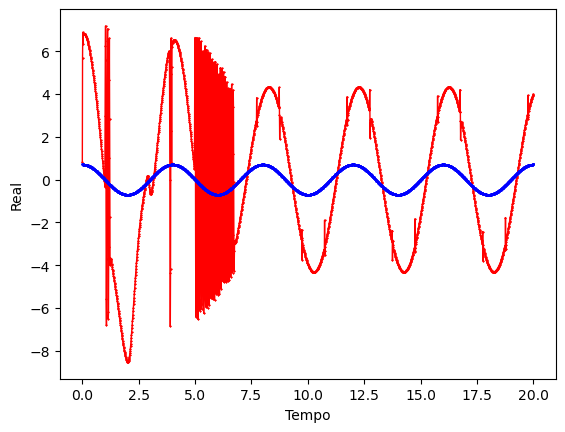

In [4]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

RealO = [ele.real for ele in Resp[0]] 
ImagO = [ele.imag for ele in Resp[0]] 

sup = []
for i in range(0, 2000):
    sup.append(1/np.sqrt(2)*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100))
RealS = [ele.real for ele in sup]
ImagS = [ele.imag for ele in sup]

sub = []
for i in range(0, 2000):
    sub.append(abs(Resp[0][i] - sup[i]))

# Plotagem
plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.plot(ts, RealO, color='r', marker='*', linewidth=1, markersize=1)
plt.plot(ts, RealS, color='b', marker='o',  linewidth=1, markersize=1)
plt.savefig('rk_otimo1_cx.png', format='png')
plt.show()

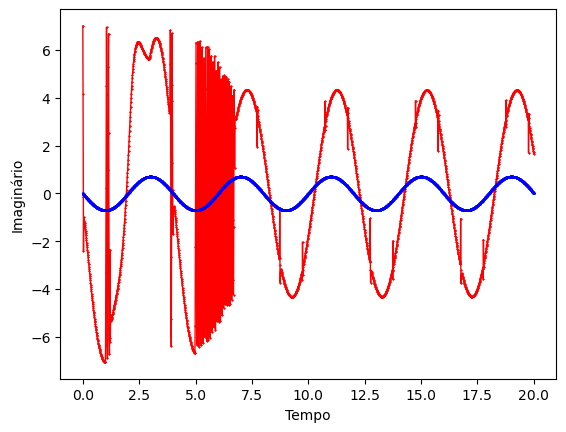

In [5]:
plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.plot(ts, ImagO, color='r', marker='*', linewidth=1, markersize=1)
plt.plot(ts, ImagS, color='b', marker='o',  linewidth=1, markersize=1)
plt.savefig('rk_otimo2_cx.png', format='png')
plt.show()

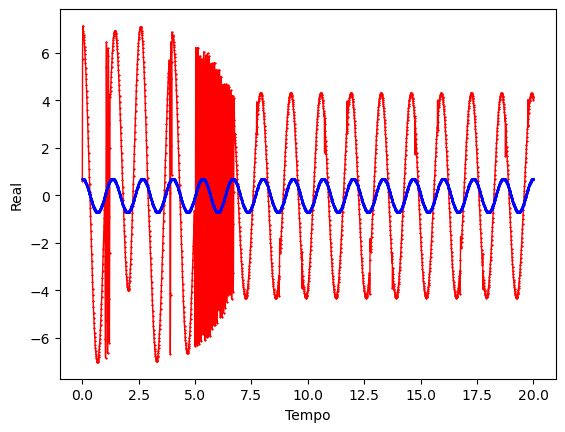

In [6]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

RealO = [ele.real for ele in Resp[1]] 
ImagO = [ele.imag for ele in Resp[1]] 

sup = []
for i in range(0, 2000):
    sup.append(1/np.sqrt(2)*np.exp(-3*complex(0,1)*(1/2*np.pi)*i/100))
RealS = [ele.real for ele in sup]
ImagS = [ele.imag for ele in sup]

subr = []
for i in range(0, 2000):
    subr.append(abs(Resp[1][i] - sup[i]))

# Plotagem
plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.plot(ts, RealO, color='r', marker='*', linewidth=1, markersize=1)
plt.plot(ts, RealS, color='b', marker='o',  linewidth=1, markersize=1)
plt.savefig('rk_otimo3_cx.png', format='png')
plt.show()

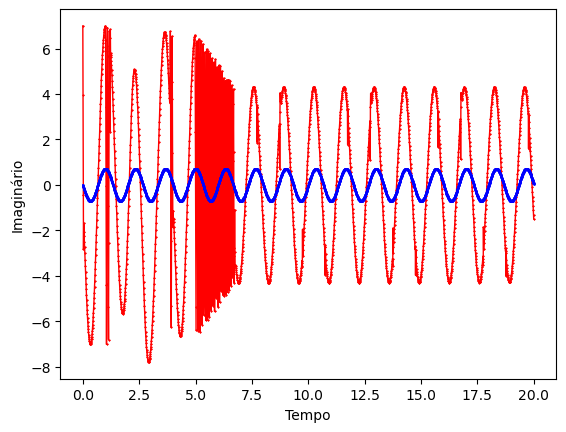

In [7]:
plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.plot(ts, ImagO, color='r', marker='*', linewidth=1, markersize=1)
plt.plot(ts, ImagS, color='b', marker='o',  linewidth=1, markersize=1)
plt.savefig('rk_otimo4_cx.png', format='png')
plt.show()

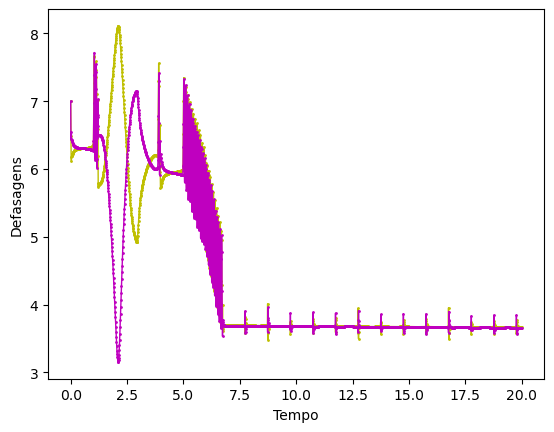

In [8]:
plt.ylabel('Defasagens') 
plt.xlabel('Tempo') 
plt.plot(ts, sub, color='y', marker='o',  linewidth=1, markersize=1)
plt.plot(ts, subr, color='m', marker='o',  linewidth=1, markersize=1)
plt.savefig('phases_cx.png', format='png')
plt.show()

#### Valor da defasagem

In [9]:
print(subr[999])

3.679667538404378


## Gráficos - Avaliação das constantes da função de onda

Outra interpretação pertinente é a obtenção das constantes de onda, pois o objetivo inicial da pesquisa é sair de uma constante e chegar em um estado de forma que estas estajam em total equilíbrio. Para realizar a plotagem com os diversos números complexos se faz o uso do número absoluto que para o estudo do conjunto complexo representa o seu tamanho, dessa forma, é possível indentificar se o estado inicial alcançou o final desejado.

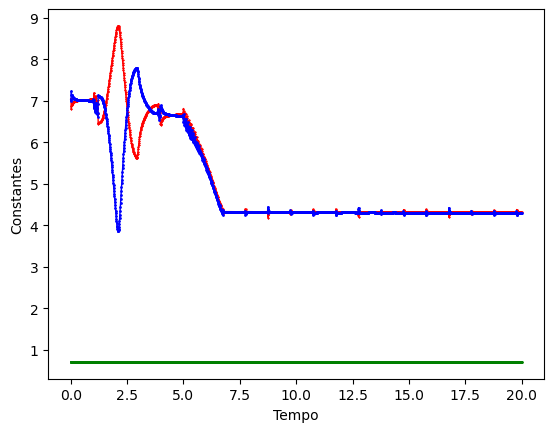

In [10]:
ts = np.linspace(0, 20, 2000) # Tempo em x 
const = []
for i in range(0, 2000):
    const.append(1/np.sqrt(2))

# Plotagem
plt.ylabel('Constantes') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(Constantes[0]), color='r', marker='*', linewidth=1, markersize=1)
plt.plot(ts, abs(Constantes[1]), color='b', marker='o',  linewidth=1, markersize=1)
plt.plot(ts, const, color='g', marker='o',  linewidth=1, markersize=1)
plt.savefig('const_cx.png', format='png')
plt.show()

## Gráficos - Avaliação da densidade de probabilidade para encontrar uma partícula no ponto x

Conforme descrito durante os capítulos 1, 2 e 3 do livro Mecânica Quântica por David Griffths, a estatística é um dos principais pontos para o entendimento da mecânica quântica, dessa forma é interessante entender qual é a probabilidade de uma partícula estar em um determinado lugar em um certo tempo e para tal se define:$$\int |\Psi(x,t)|^{2}dx = 1$$ Ainda nessa perspectiva, foi definido que o resultado da equação de Schrödinger pode ser definido a partir da escolha do potêncial V(x,t) e ainda que os enumeros resultados podem formar outros por meio de uma combinação linear de forma que o conjunto do quadrado das constantes que o formam, em sua soma resultam em 1. Isso define a probabilidade de um estado. Para este estudo considerou-se dois estados: $$0.80\psi_0(x,t)+0.60\psi_1(x,t)$$ de forma que para o primeiro estado a probabilidade é de 64% enquanto para o segundo é de 36%.

Se torna claro que a probabilidade total deve ser 1 e definindo o produto interno como $\int |\Psi(x,t)|^{2}dx = <\Psi | \Psi> = 1 = \sum_n |c_n|²$ podemos verificar se o ajuste da pesquisa está correto avaliando as constantes que são alteradas conforme o tempo de acordo com o gráfico apresentado acima.

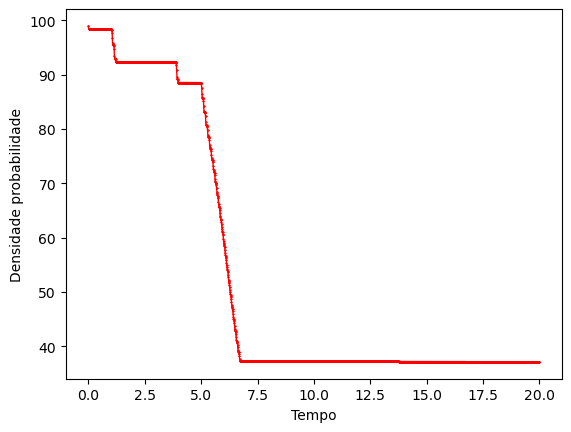

In [11]:
# Plotagem

dp = []
for i in range(0, 2000):
    dp.append((abs(Constantes[0][i])**2+abs(Constantes[1][i])**2))
    
plt.ylabel('Densidade probabilidade') 
plt.xlabel('Tempo') 
plt.plot(ts, dp, color='r', marker='*', linewidth=1, markersize=1)
plt.savefig('dp_cx.png', format='png')
plt.show()

In [12]:
print(dp)

[99.00000000000001, 98.50359946737512, 98.39688826572107, 98.39483836839246, 98.39477461546718, 98.39477459941523, 98.39477459402883, 98.39477458882061, 98.39477458338287, 98.39477457758775, 98.39477457143963, 98.39477456500751, 98.3947745583576, 98.39477455152354, 98.39477454455533, 98.39477453748415, 98.3947745303285, 98.39477452310098, 98.3947745158303, 98.39477450852999, 98.39477450118972, 98.39477449381968, 98.39477448643376, 98.39477447903573, 98.39477447161474, 98.39477446418707, 98.39477445675095, 98.39477444929952, 98.39477444184209, 98.39477443438238, 98.39477442691808, 98.39477441944798, 98.39477441197603, 98.39477440449625, 98.3947743970144, 98.39477438953219, 98.39477438204858, 98.39477437456378, 98.3947743670773, 98.39477435958861, 98.39477435210087, 98.3947743446109, 98.39477433712123, 98.39477432963017, 98.3947743221384, 98.39477431464735, 98.39477430715652, 98.39477429966536, 98.39477429217365, 98.39477428468194, 98.39477427719012, 98.39477426969827, 98.3947742622064, 